### Data Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
# Set plotting style 
sns.set_style("whitegrid")

Load the Dataset

In [3]:
print("--- 1. Loading Dataset  ---")
file_path = '../data/creditcard.csv'
try:
    df_2013 = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: Dataset not found at {file_path}. Please check the path.")
    exit()

print("Original DataFrame head:")
print(df_2013.head())
print("\n" + "="*80 + "\n")

--- 1. Loading Dataset  ---
Dataset '../data/creditcard.csv' loaded successfully.
Original DataFrame head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.2

Feature Engineering : 'Hour of Day'

In [4]:
# --- 2. Feature Engineering: 'Hour of Day' ---
print("--- 2. Feature Engineering: 'Hour of Day' ---")

# Convert Time from seconds to hours
df_2013['Time_Hour'] = df_2013['Time'] / 3600

# Create 'Hour_of_Day' feature (cyclic pattern)
# Modulo 24 will give the hour of the day (assuming continuous time is within 48 hours for 2 days)
df_2013['Hour_of_Day'] = df_2013['Time_Hour'] % 24

print("DataFrame head with new 'Time_Hour' and 'Hour_of_Day' features:")
print(df_2013[['Time', 'Time_Hour', 'Hour_of_Day', 'Class']].head())


print("DataFrame tail with new 'Time_Hour' and 'Hour_of_Day' features:")
print(df_2013[['Time', 'Time_Hour', 'Hour_of_Day', 'Class']].tail())


--- 2. Feature Engineering: 'Hour of Day' ---
DataFrame head with new 'Time_Hour' and 'Hour_of_Day' features:
   Time  Time_Hour  Hour_of_Day  Class
0   0.0   0.000000     0.000000      0
1   0.0   0.000000     0.000000      0
2   1.0   0.000278     0.000278      0
3   1.0   0.000278     0.000278      0
4   2.0   0.000556     0.000556      0
DataFrame tail with new 'Time_Hour' and 'Hour_of_Day' features:
            Time  Time_Hour  Hour_of_Day  Class
284802  172786.0  47.996111    23.996111      0
284803  172787.0  47.996389    23.996389      0
284804  172788.0  47.996667    23.996667      0
284805  172788.0  47.996667    23.996667      0
284806  172792.0  47.997778    23.997778      0


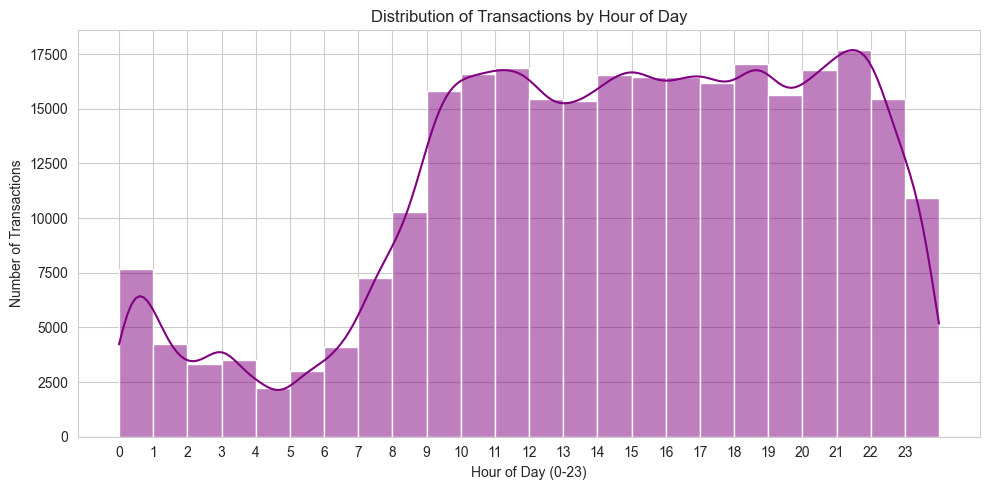


Insight: The 'Hour_of_Day' feature captures cyclical patterns that might be important for fraud detection, as suggested by EDA.




In [5]:
# Visualize the new 'Hour_of_Day' distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_2013['Hour_of_Day'], bins=24, kde=True, color='purple')
plt.title('Distribution of Transactions by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

print("\nInsight: The 'Hour_of_Day' feature captures cyclical patterns that might be important for fraud detection, as suggested by EDA.")
print("\n" + "="*80 + "\n")

Feature Scaling

In [6]:
# --- 3. Feature Scaling ---
print("--- 3. Feature Scaling ---")

# Initialize StandardScaler
scaler = StandardScaler()

# Features to be scaled: 'Amount' and the engineered 'Hour_of_Day'.
# We generally don't scale PCA components (V1-V28) as they are already standardized.
# 'Time' is also a candidate, but 'Hour_of_Day' captures the more relevant cyclical aspect.
# Let's scale both 'Time' (for linear progression aspect) and 'Hour_of_Day' (for cyclical aspect)
# and 'Amount'. We can decide later which combination works best.

features_to_scale = ['Time', 'Hour_of_Day', 'Amount']

# Fit and transform the selected features
df_2013[features_to_scale] = scaler.fit_transform(df_2013[features_to_scale])

print("DataFrame head after scaling 'Time', 'Hour_of_Day', and 'Amount':")
print(df_2013[features_to_scale + ['Class']].head())
print("\nSummary statistics of scaled features:")
print(df_2013[features_to_scale].describe())

print("\nInsight: 'Time', 'Hour_of_Day', and 'Amount' features have been scaled to have a mean of ~0 and standard deviation of ~1, bringing them to a similar scale as the PCA components.")
print("\n" + "="*160 + "\n")

--- 3. Feature Scaling ---
DataFrame head after scaling 'Time', 'Hour_of_Day', and 'Amount':
       Time  Hour_of_Day    Amount  Class
0 -1.996583    -2.486373  0.244964      0
1 -1.996583    -2.486373 -0.342475      0
2 -1.996562    -2.486326  1.160686      0
3 -1.996562    -2.486326  0.140534      0
4 -1.996541    -2.486278 -0.073403      0

Summary statistics of scaled features:
               Time   Hour_of_Day        Amount
count  2.848070e+05  2.848070e+05  2.848070e+05
mean  -3.065637e-16 -6.450611e-16  2.913952e-17
std    1.000002e+00  1.000002e+00  1.000002e+00
min   -1.996583e+00 -2.486373e+00 -3.532294e-01
25%   -8.552120e-01 -6.738023e-01 -3.308401e-01
50%   -2.131453e-01  8.087540e-02 -2.652715e-01
75%    9.372174e-01  8.195194e-01 -4.471707e-02
max    1.642058e+00  1.618165e+00  1.023622e+02

Insight: 'Time', 'Hour_of_Day', and 'Amount' features have been scaled to have a mean of ~0 and standard deviation of ~1, bringing them to a similar scale as the PCA components.




Define Features (X) and Target (y)

In [7]:
print("--- 4. Defining Features (X) and Target (y) ---")

# Drop the intermediate 'Time_Hour' as 'Hour_of_Day' is the primary engineered feature.
# 'Time' (original, now scaled) is kept as it might still carry linear temporal info.
# 'Class' is the target variable.

# All V features + scaled Time + scaled Hour_of_Day + scaled Amount
X = df_2013.drop(['Class', 'Time_Hour'], axis=1) # Exclude 'Class' and the intermediate 'Time_Hour'
y = df_2013['Class']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)
print("\nFirst 5 rows of X (features):")
print(X.head())
print("\nFirst 5 rows of y (target):")
print(y.head())

print("\nInsight: Features (X) and target (y) have been successfully separated.")
print("\n" + "="*80 + "\n")

--- 4. Defining Features (X) and Target (y) ---
Shape of X (features): (284807, 31)
Shape of y (target): (284807,)

First 5 rows of X (features):
       Time        V1        V2        V3        V4        V5        V6  \
0 -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  

Train-Test Split

In [8]:
# --- 5. Train-Test Split ---
print("--- 5. Train-Test Split ---")

# Split the data into training and testing sets
# test_size=0.20 means 20% for testing, 80% for training
# random_state for reproducibility
# stratify=y is CRUCIAL for highly imbalanced datasets to maintain class distribution in both splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

--- 5. Train-Test Split ---
Shape of X_train: (227845, 31)
Shape of y_train: (227845,)
Shape of X_test: (56962, 31)
Shape of y_test: (56962,)


In [9]:
# Verify class distribution in training and testing sets
print("\nClass distribution in original dataset:")
print(y.value_counts(normalize=True) * 100)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

print("\nInsight: Data successfully split into training and testing sets, with class distribution preserved due to stratification. This ensures reliable evaluation of models, especially for the rare fraud class.")
print("\n" + "="*80 + "\n")



Class distribution in original dataset:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Class distribution in training set:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64

Class distribution in testing set:
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64

Insight: Data successfully split into training and testing sets, with class distribution preserved due to stratification. This ensures reliable evaluation of models, especially for the rare fraud class.




Data Integrity and Saving

In [10]:
# --- 7. Data Integrity and Saving ---
print("--- 7. Data Integrity and Saving ---")
# Check for NaN values post-processing
print("NaN check after preprocessing:", df_2013[features_to_scale].isnull().sum().sum())

output_dir = '../data'  
os.makedirs(output_dir, exist_ok=True)
# Save preprocessed data as .pkl
output_filename = os.path.join(output_dir, 'preprocessed_data_2013.pkl')
joblib.dump((X_train, X_test, y_train, y_test), output_filename)
print(f"Preprocessed data saved to {output_filename}")

--- 7. Data Integrity and Saving ---
NaN check after preprocessing: 0
Preprocessed data saved to ../data\preprocessed_data_2013.pkl


In [11]:
# Verify saved file
loaded_data = joblib.load('../data/preprocessed_data_2013.pkl')
print("Loaded data shapes:", [d.shape for d in loaded_data[:4]])

print("\nInsight: Data integrity verified, and preprocessed splits saved as .pkl for efficient modeling.")
print("\n" + "="*80 + "\n")

print("--- Data Preprocessing for creditcard.csv (2013) Complete ---")

Loaded data shapes: [(227845, 31), (56962, 31), (227845,), (56962,)]

Insight: Data integrity verified, and preprocessed splits saved as .pkl for efficient modeling.


--- Data Preprocessing for creditcard.csv (2013) Complete ---


### Handling Imbalance and Model Selection

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For loading preprocessed data
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  
# If you prefer LightGBM, replace XGBClassifier with lgb.LGBMClassifier
# import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # For hyperparameter tuning later, but good to import
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek  # For hybrid approach

In [13]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size for plots

In [14]:
# Define a random state for reproducibility across all models and resampling
RANDOM_STATE = 42

Load Preprocessed Data

In [15]:
# --- 1. Load Preprocessed Data ---
print("--- 1. Loading Preprocessed Data ---")
try:
    X_train, X_test, y_train, y_test = joblib.load('../data/preprocessed_data_2013.pkl')
    print("Preprocessed data loaded successfully.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
except FileNotFoundError:
    print("Error: 'preprocessed_data.pkl' not found. Please ensure Phase 1, Step 2 was completed and saved the file.")
    exit()
print("\n" + "="*80 + "\n")

--- 1. Loading Preprocessed Data ---
Preprocessed data loaded successfully.
X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)




Evaluation Function

In [16]:
# --- 2. Define Evaluation Function ---
# This function will be reused for all model evaluations.
def evaluate_model(model, X_test, y_test, model_name, strategy_name, results_list):
    """
    Evaluates a trained classification model and prints key metrics,
    plots the Precision-Recall curve, and stores results.
    Args:
        model: Trained scikit-learn compatible classifier.
        X_test: Test features.
        y_test: True test labels.
        model_name (str): Name of the model (e.g., 'Logistic Regression').
        strategy_name (str): Name of the imbalance handling strategy.
        results_list (list): List to append model results.
    """
    print(f"--- Evaluating {model_name} with {strategy_name} ---")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class (fraud)

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {model_name} ({strategy_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # 3. ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # 4. Precision-Recall Curve & AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC (AUPRC): {pr_auc:.4f}")
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall (Fraud)')
    plt.ylabel('Precision (Fraud)')
    plt.title(f'Precision-Recall Curve: {model_name} ({strategy_name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Store results for later comparison
    metrics = {
        'Model': model_name,
        'Strategy': strategy_name,
        'Accuracy': (cm[0,0] + cm[1,1]) / np.sum(cm),
        'Precision (Fraud)': precision_score(y_test, y_pred, pos_label=1),  # Ensure pos_label is 1 for fraud
        'Recall (Fraud)': recall_score(y_test, y_pred, pos_label=1),
        'F1-Score (Fraud)': f1_score(y_test, y_pred, pos_label=1),
        'ROC AUC': roc_auc,
        'AUPRC': pr_auc,
        'True Positives (TP)': cm[1,1],
        'False Positives (FP)': cm[0,1],
        'False Negatives (FN)': cm[1,0]
    }
    results_list.append(metrics)
print("\n" + "="*80 + "\n")  # Separator

# Initialize a list to store results for all models and strategies
results_list = []

Model Training and Evaluation Strategies

In [17]:
# --- 3. Model Training and Evaluation Strategies ---

Strategy A: Baseline Model (No Imbalance Handling)

--- Strategy A: Baseline Model (No Imbalance Handling) ---
--- Evaluating Logistic Regression with No Handling ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56851    13]
 [   35    63]]


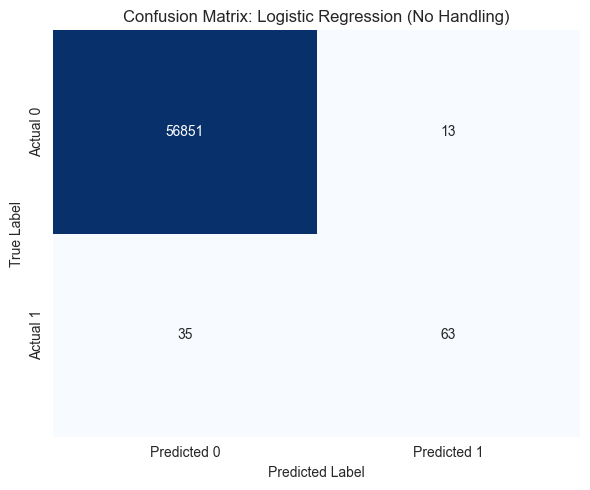


ROC AUC Score: 0.9588
Precision-Recall AUC (AUPRC): 0.7432


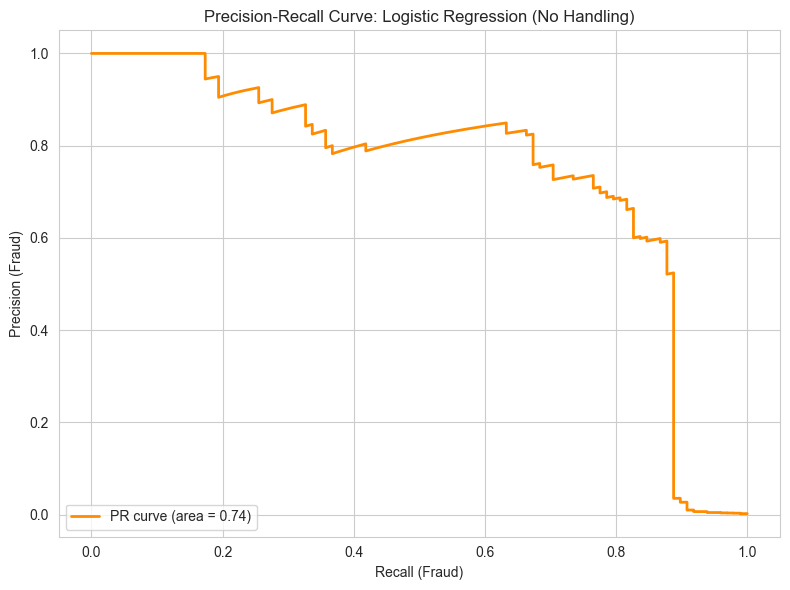

In [18]:
# --- Strategy A: Baseline Model (No Imbalance Handling) ---
print("--- Strategy A: Baseline Model (No Imbalance Handling) ---")
lr_baseline = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)  # 'liblinear' good for small datasets, default 'lbfgs' too
lr_baseline.fit(X_train, y_train)
evaluate_model(lr_baseline, X_test, y_test, 'Logistic Regression', 'No Handling', results_list)

Strategy B: Class Weighting

In [19]:
# --- Strategy B: Class Weighting ---
print("--- Strategy B: Class Weighting ---")
# Calculate scale_pos_weight for XGBoost
# This is (count of negative samples) / (count of positive samples)
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")

--- Strategy B: Class Weighting ---
Calculated scale_pos_weight for XGBoost: 577.29


--- Evaluating Logistic Regression with Class Weighting ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.98     56962


Confusion Matrix:
[[55348  1516]
 [    9    89]]


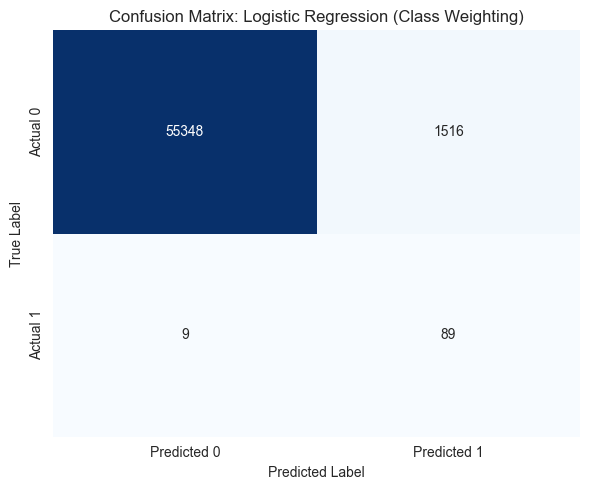


ROC AUC Score: 0.9737
Precision-Recall AUC (AUPRC): 0.7692


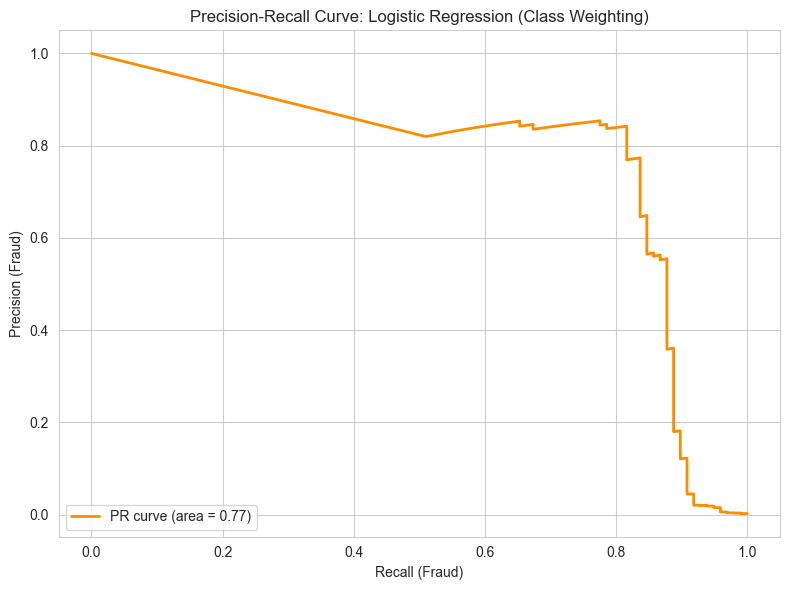

In [20]:
# Logistic Regression with Class Weights
lr_cw = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
lr_cw.fit(X_train, y_train)
evaluate_model(lr_cw, X_test, y_test, 'Logistic Regression', 'Class Weighting', results_list)

--- Evaluating Random Forest with Class Weighting ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.72      0.83        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56861     3]
 [   27    71]]


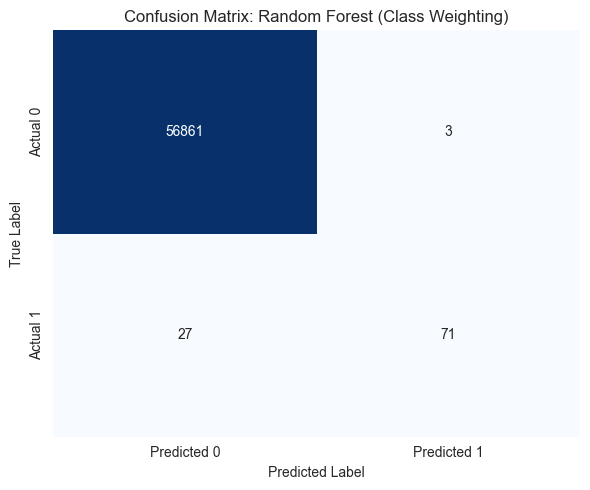


ROC AUC Score: 0.9530
Precision-Recall AUC (AUPRC): 0.8674


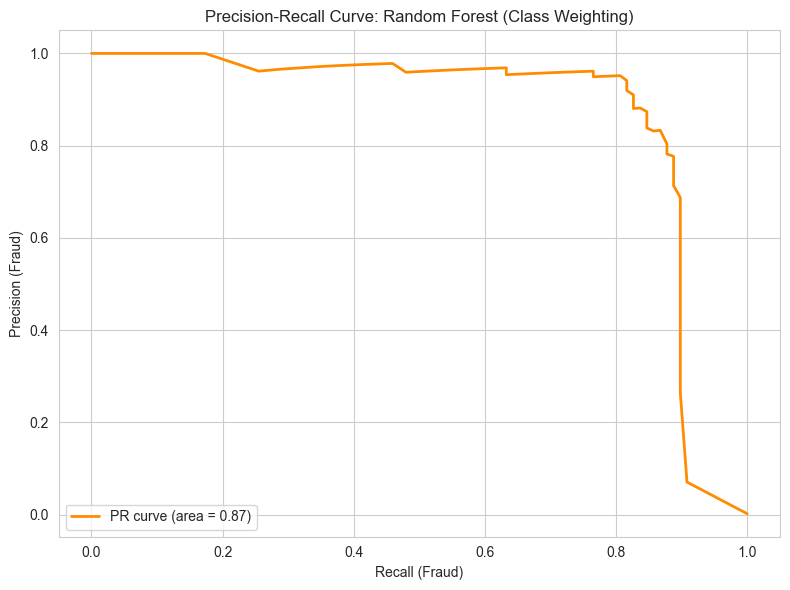

In [21]:
# Random Forest with Class Weights
rf_cw = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)  # n_jobs=-1 uses all available cores
rf_cw.fit(X_train, y_train)
evaluate_model(rf_cw, X_test, y_test, 'Random Forest', 'Class Weighting', results_list)

C:\Users\PAVITHRAN\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [23:04:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluating XGBoost with Class Weighting ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56852    12]
 [   15    83]]


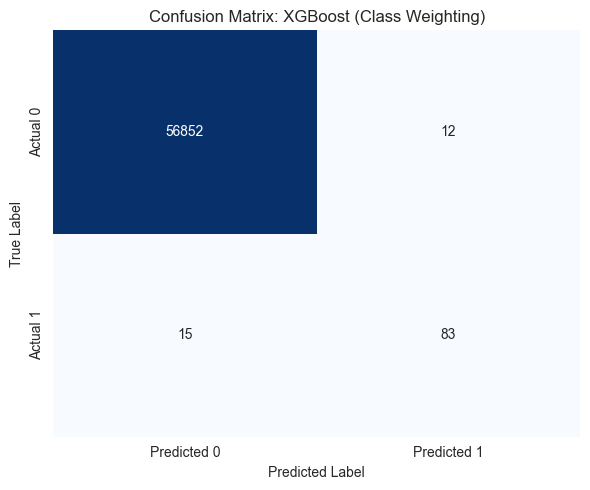


ROC AUC Score: 0.9746
Precision-Recall AUC (AUPRC): 0.8883


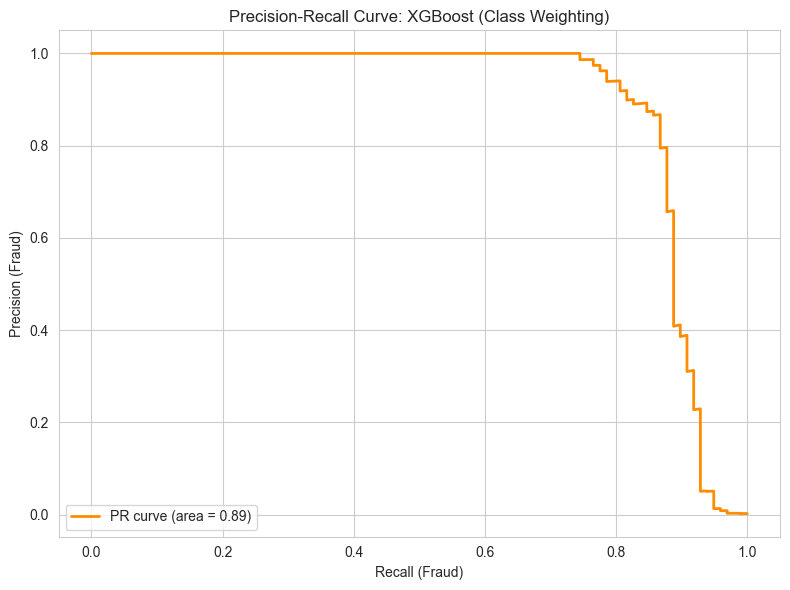

In [22]:
# XGBoost with scale_pos_weight
xgb_cw = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                      scale_pos_weight=scale_pos_weight_value, random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
xgb_cw.fit(X_train, y_train)
evaluate_model(xgb_cw, X_test, y_test, 'XGBoost', 'Class Weighting', results_list)

In [23]:
# --- Strategy C: Oversampling (SMOTE) ---
print("--- Strategy C: Oversampling (SMOTE) ---")
print("Applying SMOTE to training data...")
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Original training set shape: {X_train.shape}, new training set shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution after SMOTE: {y_train_smote.value_counts()}")

--- Strategy C: Oversampling (SMOTE) ---
Applying SMOTE to training data...
Original training set shape: (227845, 31), new training set shape after SMOTE: (454902, 31)
Class distribution after SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


--- Evaluating Random Forest with SMOTE Oversampling ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56849    15]
 [   18    80]]


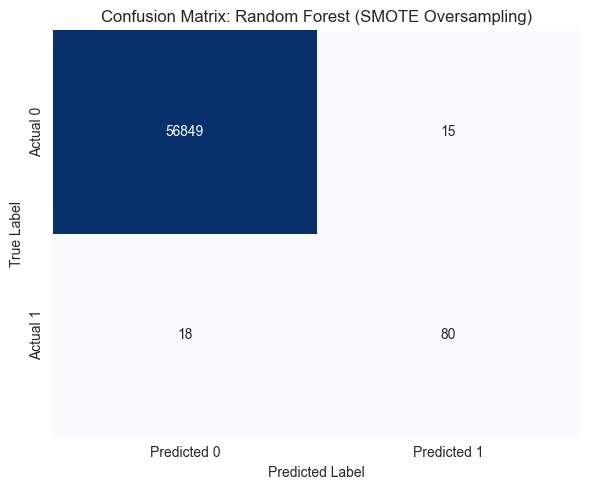


ROC AUC Score: 0.9782
Precision-Recall AUC (AUPRC): 0.8709


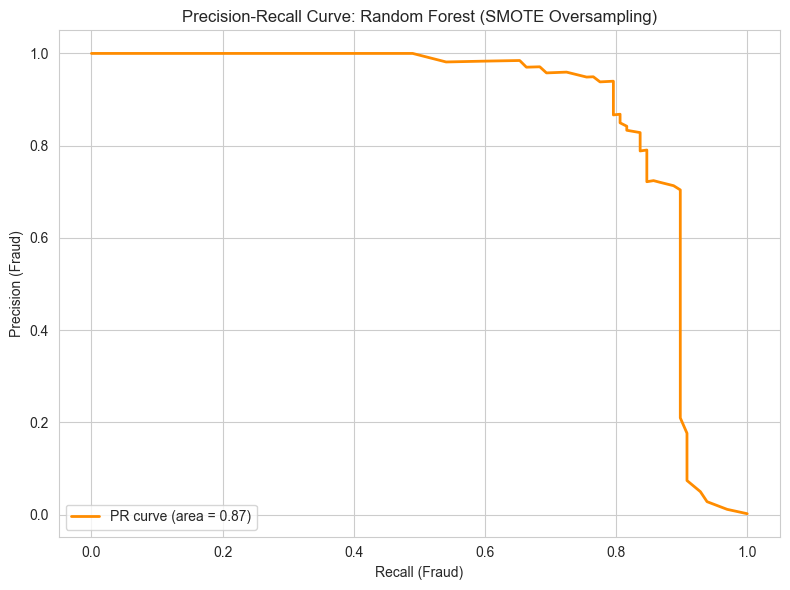

In [24]:
# Random Forest on SMOTE-resampled data
rf_smote = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
evaluate_model(rf_smote, X_test, y_test, 'Random Forest', 'SMOTE Oversampling', results_list)

C:\Users\PAVITHRAN\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [23:05:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluating XGBoost with SMOTE Oversampling ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.84      0.75        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56825    39]
 [   16    82]]


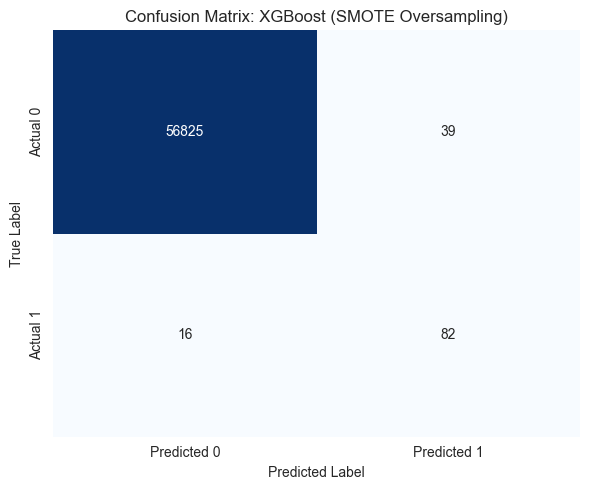


ROC AUC Score: 0.9807
Precision-Recall AUC (AUPRC): 0.8628


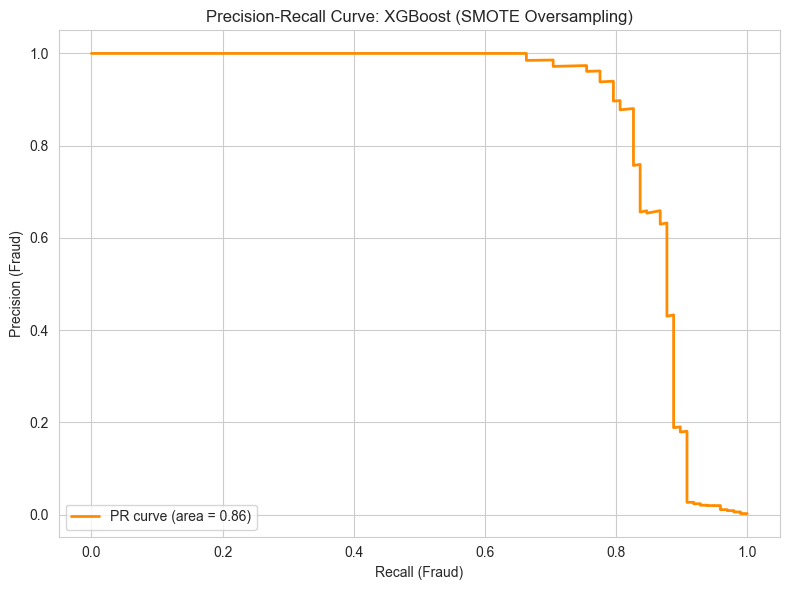

In [25]:
# XGBoost on SMOTE-resampled data
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                         random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
xgb_smote.fit(X_train_smote, y_train_smote)
evaluate_model(xgb_smote, X_test, y_test, 'XGBoost', 'SMOTE Oversampling', results_list)

In [26]:
# --- Strategy D: Undersampling (RandomUnderSampler) ---
print("--- Strategy D: Undersampling (RandomUnderSampler) ---")
print("Applying RandomUnderSampler to training data...")
rus = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f"Original training set shape: {X_train.shape}, new training set shape after RUS: {X_train_rus.shape}")
print(f"Class distribution after RUS: {y_train_rus.value_counts()}")

--- Strategy D: Undersampling (RandomUnderSampler) ---
Applying RandomUnderSampler to training data...
Original training set shape: (227845, 31), new training set shape after RUS: (788, 31)
Class distribution after RUS: Class
0    394
1    394
Name: count, dtype: int64


--- Evaluating Logistic Regression with RUS Undersampling ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962


Confusion Matrix:
[[54656  2208]
 [    8    90]]


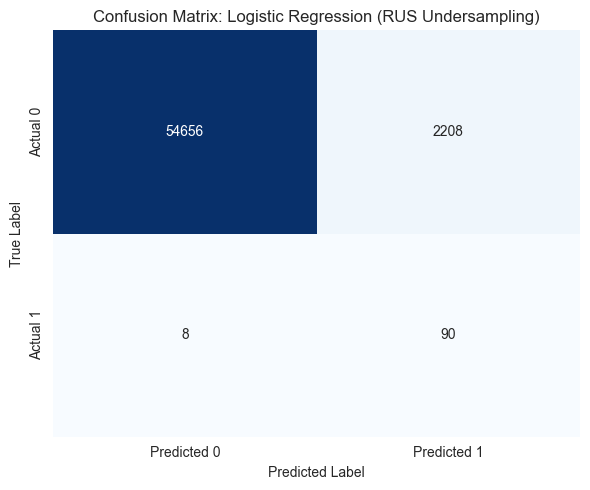


ROC AUC Score: 0.9769
Precision-Recall AUC (AUPRC): 0.7146


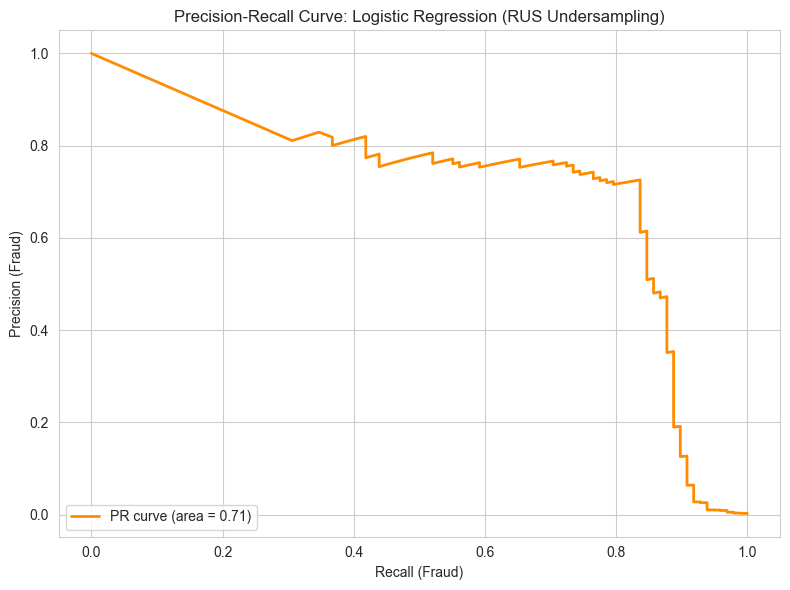

In [27]:
# Logistic Regression on RandomUndersampler-resampled data
lr_rus = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
lr_rus.fit(X_train_rus, y_train_rus)
evaluate_model(lr_rus, X_test, y_test, 'Logistic Regression', 'RUS Undersampling', results_list)

In [28]:
# --- Strategy E: Hybrid (SMOTETomek) ---
print("--- Strategy E: Hybrid (SMOTETomek) ---")
print("Applying SMOTETomek to training data...")
smt = SMOTETomek(random_state=RANDOM_STATE)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print(f"Original training set shape: {X_train.shape}, new training set shape after SMOTETomek: {X_train_smt.shape}")
print(f"Class distribution after SMOTETomek: {y_train_smt.value_counts()}")

--- Strategy E: Hybrid (SMOTETomek) ---
Applying SMOTETomek to training data...
Original training set shape: (227845, 31), new training set shape after SMOTETomek: (454902, 31)
Class distribution after SMOTETomek: Class
0    227451
1    227451
Name: count, dtype: int64


--- Evaluating Random Forest with SMOTETomek Hybrid ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56849    15]
 [   18    80]]


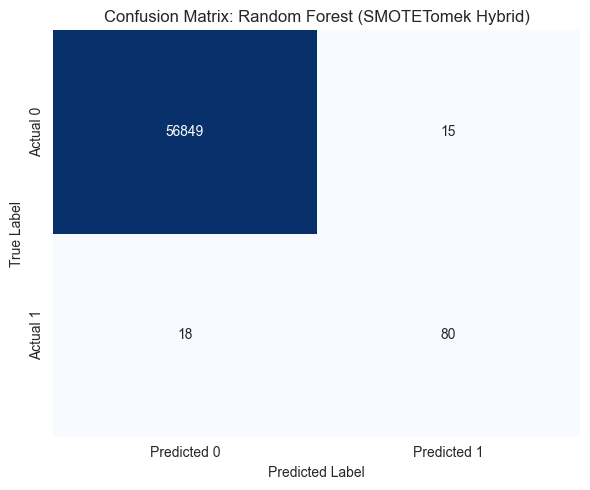


ROC AUC Score: 0.9782
Precision-Recall AUC (AUPRC): 0.8709


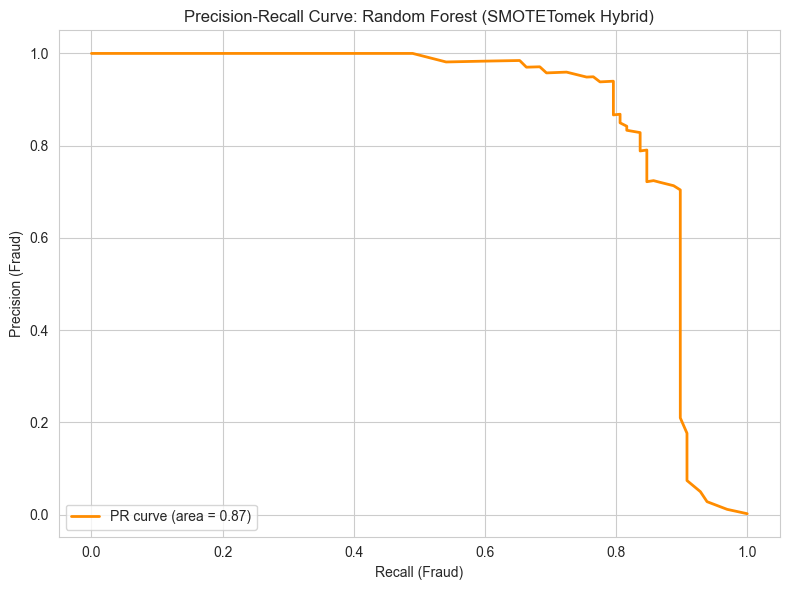

In [29]:
# Random Forest on SMOTETomek-resampled data
rf_smt = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
rf_smt.fit(X_train_smt, y_train_smt)
evaluate_model(rf_smt, X_test, y_test, 'Random Forest', 'SMOTETomek Hybrid', results_list)

Initial Performance Comparison Summary

In [30]:
# --- 4. Initial Performance Comparison Summary ---
print("--- 4. Initial Performance Comparison Summary ---")
results_df = pd.DataFrame(results_list)

# Sort by AUPRC (descending) as it's a robust metric for imbalanced data
results_df_sorted = results_df.sort_values(by='AUPRC', ascending=False)

print("\nSummary of Model Performance (Sorted by AUPRC):")
print(results_df_sorted[['Model', 'Strategy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUPRC', 'ROC AUC', 'True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)']
].round(4))

print("\nInsight: Review the table above to identify which models and imbalance handling strategies provide the best balance of Precision, Recall, F1-Score, and AUPRC for fraud detection.")

print("\n" + "="*80 + "\n")
print("--- Phase 1, Step 3: Handling Imbalanced Data & Model Selection Complete ---")

--- 4. Initial Performance Comparison Summary ---

Summary of Model Performance (Sorted by AUPRC):
                 Model            Strategy  Precision (Fraud)  Recall (Fraud)  \
3              XGBoost     Class Weighting             0.8737          0.8469   
4        Random Forest  SMOTE Oversampling             0.8421          0.8163   
7        Random Forest   SMOTETomek Hybrid             0.8421          0.8163   
2        Random Forest     Class Weighting             0.9595          0.7245   
5              XGBoost  SMOTE Oversampling             0.6777          0.8367   
1  Logistic Regression     Class Weighting             0.0555          0.9082   
0  Logistic Regression         No Handling             0.8289          0.6429   
6  Logistic Regression   RUS Undersampling             0.0392          0.9184   

   F1-Score (Fraud)   AUPRC  ROC AUC  True Positives (TP)  \
3            0.8601  0.8883   0.9746                   83   
4            0.8290  0.8709   0.9782             